In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import time
import sys, os

os.environ["TMPDIR"] = "/disk/scratch/mhennig/tmp"
os.environ["TEMPDIR"] = "/disk/scratch/mhennig/tmp"

os.environ["KILOSORT2_PATH"] = "/disk/scratch/mhennig/spikeinterface/Kilosort2/"
os.environ["NPY_MATLAB_PATH"] = "/disk/scratch/mhennig/spikeinterface/npy-matlab/"
os.environ["KILOSORT_PATH"] = "/disk/scratch/mhennig/spikeinterface/KiloSort/"
os.environ["IRONCLUST_PATH"] = "/disk/scratch/mhennig/spikeinterface/ironclust"

import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
import tempfile
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from spikecomparison import GroundTruthStudy
import networkx as nx

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   

%matplotlib inline

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


# Load data and sorter results

In [2]:
# MEArec dataset
p = Path('/disk/scratch/mhennig/spikeinterface/paper/MEArec/')
study_folder = p / 'study_mearec_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28/'
mearec_filename = Path('/disk/scratch/mhennig/MEArec') / 'recordings_250cells_Neuropixels-384chans_duration600s_noise10uV_2020-02-28.h5'
SX_gt = se.MEArecSortingExtractor(mearec_filename)
RX = se.MEArecRecordingExtractor(mearec_filename)

In [3]:
# Load groundtruth study folder (needs an already sorted groundtruth study)
study = GroundTruthStudy(study_folder)
# sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
#                'spykingcircus', 'tridesclous', 'mountainsort4']
# sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
#                'SpykingCircus', 'Tridesclous', 'Mountainsort4']
# sorter_names_short = ['HS2', 'KS2', 'IC', 'SC', 'TDC', 'MS4']
sorter_list = ['herdingspikes', 'kilosort2', 'ironclust',
               'spykingcircus', 'tridesclous']
sorter_names = ['HerdingSpikes', 'Kilosort2', 'Ironclust',
               'SpykingCircus', 'Tridesclous']
sorter_names_short = ['HS2', 'KS2', 'IC', 'SC', 'TDC']

In [4]:
for s in sorter_list:
    print(s+': '+ss.sorter_dict[s].get_sorter_version())

herdingspikes: 0.3.7
kilosort2: git-67a42a87b866
ironclust: 5.9.3
spykingcircus: 0.9.5
tridesclous: 1.5.0


In [5]:
study.run_sorters(sorter_list, mode='keep', engine='loop', verbose=True)

In [6]:
# GT unit SNR
snr_file = study_folder / 'snr.pickle'
if os.path.isfile(snr_file):
    snr = pd.read_pickle(snr_file)
else:
    print('SNR not found')

Text(0.5, 0, 'GT units SNR')

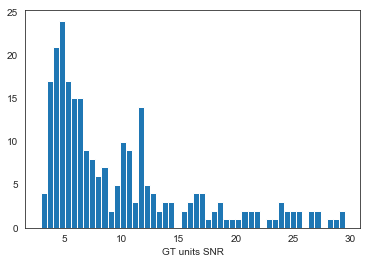

In [7]:
fig, ax = plt.subplots()
ax.hist(snr.values, bins=50)
ax.set_xlabel('GT units SNR')

# Perform ground truth comparison

In [8]:
study.run_comparisons(exhaustive_gt=True)#, match_score=0.1, overmerged_score=0.2)

In [9]:
# this retrieves the comprison results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [10]:
dataframes['run_times']

,rec_name,sorter_name,run_time
0,rec0,tridesclous,5942.924653
1,rec0,spykingcircus,7422.429900
2,rec0,herdingspikes,958.637008
3,rec0,kilosort2,633.650132
4,rec0,ironclust,709.431790


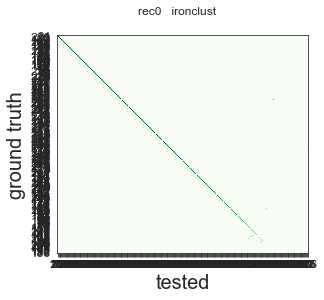

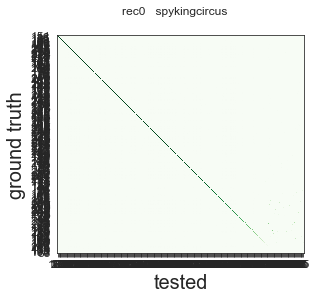

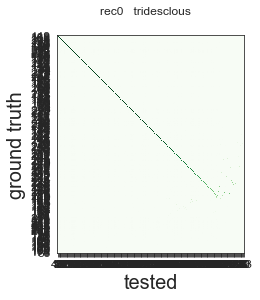

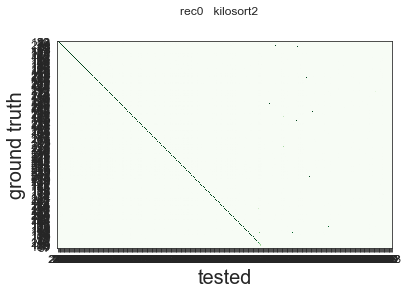

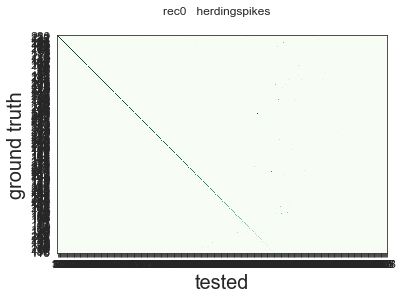

In [11]:
for (rec_name, sorter_name), comp in comparisons.items():
    fig, ax = plt.subplots()
    sw.plot_agreement_matrix(comp, ax=ax, count_text=False)
    fig.suptitle(rec_name+'   '+ sorter_name)

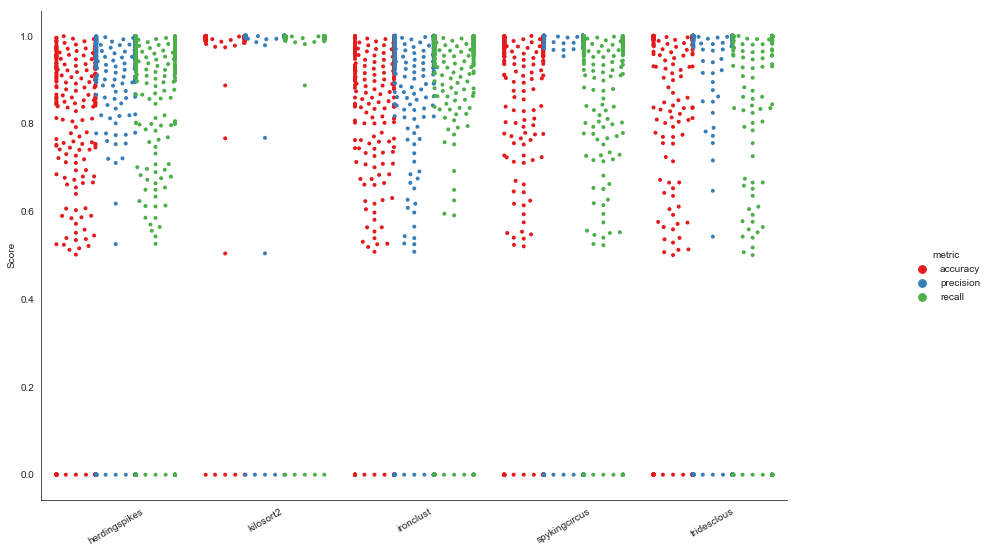

In [12]:
sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('accuracy','precision', 'recall'))
grid = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True,
                order=sorter_list, legend_out=True, s=4)
ax = grid.fig.axes[0]
ax.set_xticklabels(sorter_list, rotation=30, ha='center')
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)
grid.fig.set_size_inches(15,8)

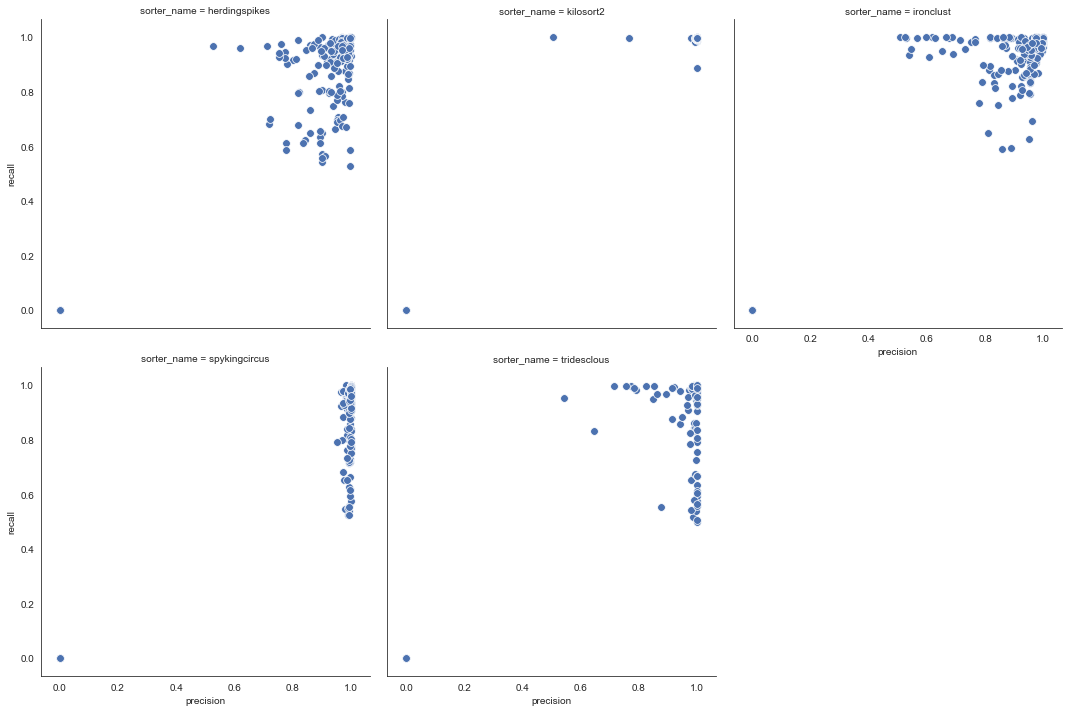

In [13]:
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], 
                x='precision', y='recall', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)

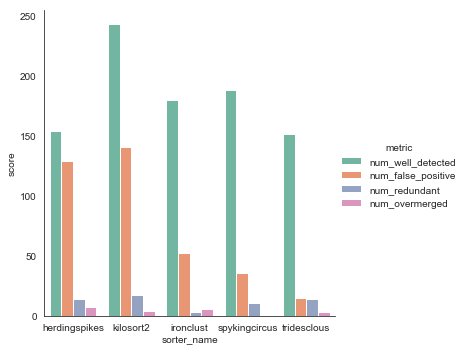

In [14]:
sns.set_palette(sns.color_palette("Set2"))

df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
grid = sns.catplot(x='sorter_name', y='score', hue='metric', data=df,
                kind="bar", order=sorter_list)
ax.set_xticklabels(sorter_list, rotation=30, ha='right')

ax.legend(bbox_to_anchor=(0.9, 0.95), borderaxespad=0., frameon=False, labelspacing=0.2)
for t, l in zip(ax.legend_.texts,("Well detected", "False positive", "Redundant", "Overmerged")):
    t.set_text(l)

ax.set_xlabel(None);
ax.set_ylabel('Number of units');
clear_axes(ax)

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


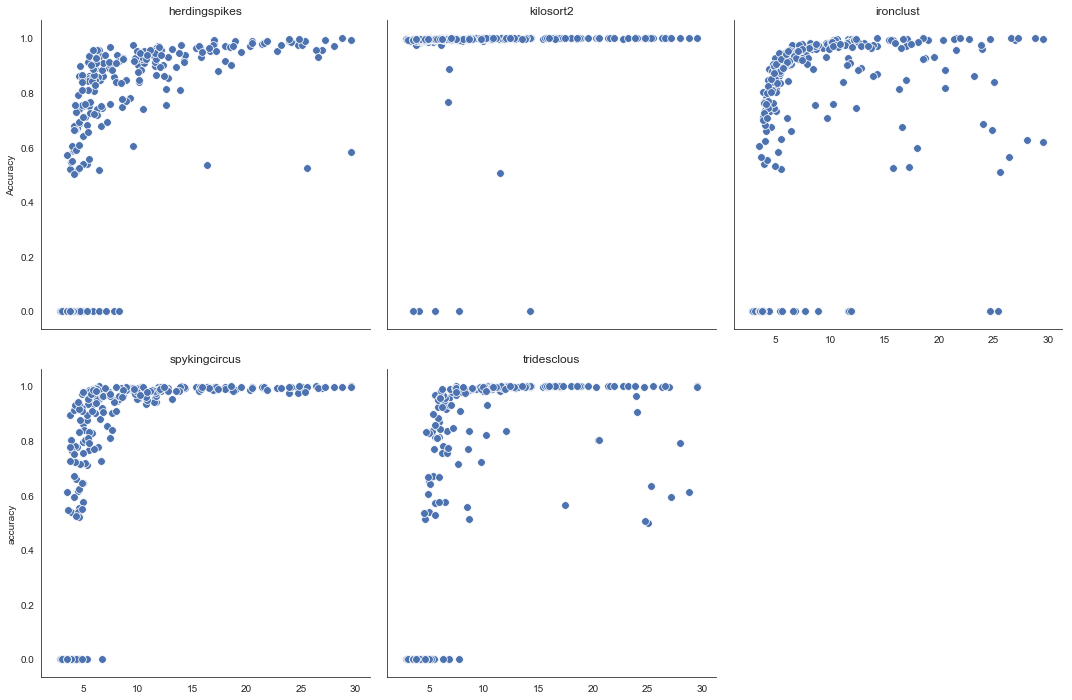

In [15]:
df = dataframes['perf_by_units']

# add snr to the by-unit table
df['snr'] = None
for gt_id in snr.index:
    df['snr'].loc[df['gt_unit_id']==gt_id] = snr.at[gt_id]

sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_list[i])
    ax.set_xlabel('')
    g.axes[0].set_xlabel('SNR');

g.axes[0].set_ylabel('Accuracy');

# Compare multiple sorters

In [16]:
sortings = []
for s in sorter_list:
    sortings.append(study.get_sorting(s))

In [17]:
mcmp = sc.compare_multiple_sorters(sorting_list=sortings, name_list=sorter_names_short, 
                                   verbose=True, match_score=0.5)
mcmp_graph = mcmp.graph.copy()

Multicomaprison step1: pairwise comparison
  Comparing:  HS2  and  KS2
  Comparing:  HS2  and  IC
  Comparing:  HS2  and  SC
  Comparing:  HS2  and  TDC
  Comparing:  KS2  and  IC
  Comparing:  KS2  and  SC
  Comparing:  KS2  and  TDC
  Comparing:  IC  and  SC
  Comparing:  IC  and  TDC
  Comparing:  SC  and  TDC
Multicomaprison step2: make graph
Multicomaprison step3: extract agreement from graph
multicomaprison step4 : make agreement spiketrains


In [18]:
# find subgraphs and get sorter IDs for each
g = mcmp_graph
subgraphs = nx.connected_component_subgraphs(g)
sg_sorters = []
sg_units = []
for i, sg in enumerate(subgraphs):
    # incomprehensible list comprehension, just trust it
    sorter_indices = [idx for node in sg.nodes for idx, sorter_name in enumerate(sorter_names_short) if sorter_name in node]
    sg_sorters.append(sorter_indices)
    sg_units.append([int(node[node.find('_')+1:]) for node in sg.nodes])
    if True in (t>1 for t in np.unique(sg_sorters[-1], return_counts=True)[1]):
        print('Found split unit (ignore in analysis):',i,'\n',sg.nodes,'\n',sg.edges,'\n',s)
        del sg_sorters[-1]
        del sg_units[-1]

Found split unit (ignore in analysis): 40 
 ['HS2_40', 'SC_238', 'KS2_33', 'IC_30', 'TDC_160', 'HS2_56'] 
 [('HS2_40', 'KS2_33'), ('HS2_40', 'IC_30'), ('HS2_40', 'SC_238'), ('SC_238', 'KS2_33'), ('SC_238', 'IC_30'), ('KS2_33', 'IC_30'), ('KS2_33', 'TDC_160'), ('TDC_160', 'HS2_56')] 
 tridesclous
Found split unit (ignore in analysis): 84 
 ['TDC_19', 'IC_47', 'KS2_49', 'SC_103', 'HS2_85', 'HS2_149'] 
 [('TDC_19', 'HS2_149'), ('TDC_19', 'KS2_49'), ('TDC_19', 'IC_47'), ('TDC_19', 'SC_103'), ('IC_47', 'KS2_49'), ('IC_47', 'SC_103'), ('KS2_49', 'HS2_149'), ('KS2_49', 'SC_103'), ('SC_103', 'HS2_85')] 
 tridesclous
Found split unit (ignore in analysis): 186 
 ['SC_114', 'KS2_202', 'TDC_125', 'SC_167', 'HS2_188', 'IC_182', 'KS2_105', 'HS2_204'] 
 [('SC_114', 'HS2_188'), ('SC_114', 'KS2_105'), ('KS2_202', 'HS2_204'), ('KS2_202', 'SC_167'), ('KS2_202', 'TDC_125'), ('TDC_125', 'HS2_204'), ('TDC_125', 'IC_182'), ('TDC_125', 'SC_167'), ('SC_167', 'HS2_204'), ('HS2_188', 'KS2_105'), ('HS2_188', 'IC_

/disk/scratch/mhennig/miniconda3/envs/spikesorting/lib/python3.7/site-packages/networkx/algorithms/components/connected.py:86: DeprecationWarning: connected_component_subgraphs is deprecated and will be removedin 2.2. Use (G.subgraph(c).copy() for c in connected_components(G))
  _warnings.warn(msg, DeprecationWarning)


# Plot agreement between sorters

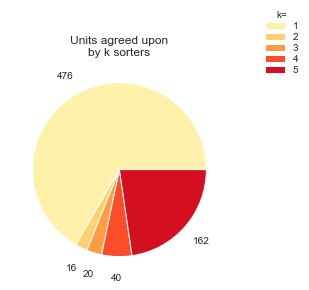

In [19]:
fs = 10
def getabs(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:d}".format(absolute)

cmap = plt.get_cmap('YlOrRd')
colors = np.array([cmap(i) for i in np.linspace(0.1, 0.8, len(sorter_names))])
    
# fraction of units with agreement >threshold  
ax = plt.subplot(111)
v,c = np.unique([len(np.unique(s)) for s in sg_sorters], return_counts=True)
p = ax.pie(c, colors=colors[v-1], autopct=lambda pct: getabs(pct, c), 
           pctdistance=1.25);
plt.title('Units agreed upon\nby k sorters'.format(len(sorter_names)));
plt.legend(p[0], v, frameon=False, title='k=',
           bbox_to_anchor=(1.15, 1.25), loc=2, borderaxespad=0., labelspacing=0.2);

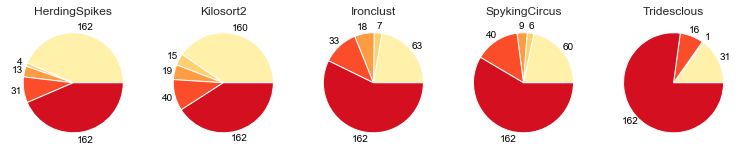

In [20]:
plt.figure(figsize=(len(sorter_names)*2.6,2.4))
fs = 10

for i,s in enumerate(sorter_names):
    plt.subplot(1,len(sorter_names),i+1)
    v,c = np.unique([len(np.unique(s)) for s in sg_sorters if i in s], return_counts=True)
    plt.pie(c, colors=colors[v-1], textprops={'color':'k', 'fontsize': fs}, autopct=lambda pct: getabs(pct, c),
           pctdistance=1.15);
    plt.title(s)

# Plot consensus and false positives

In [21]:
# get matches for GT units
gt_match = []
for s in sorter_list:
    gt_match.append(study.comparisons['rec0',s].best_match_12)
    
# iterate all subgraphs
# check if unit is matched GT unit
in_gt = []
in_gt_units = []
for sg in list(zip(sg_sorters, sg_units)):
    s,u = sg
    in_gt.append([gt_match[p[0]].isin([p[1]]).any() for p in zip(s,u)])
    if np.sum(in_gt[-1]):
        in_gt_units.append([list(gt_match[p[0]]).index(p[1]) if p[1] in list(gt_match[p[0]]) else -1 for p in zip(s,u)])
    else:
        in_gt_units.append([])
    
# for each subgraph, count number found/not found
found = []
notfound = []
for sg in list(zip(sg_sorters, sg_units, in_gt)):
    s,u,num = sg
    found.append((len(u),np.sum(num)))
    num = ~np.array(num)
    notfound.append((len(u),np.sum(num)))

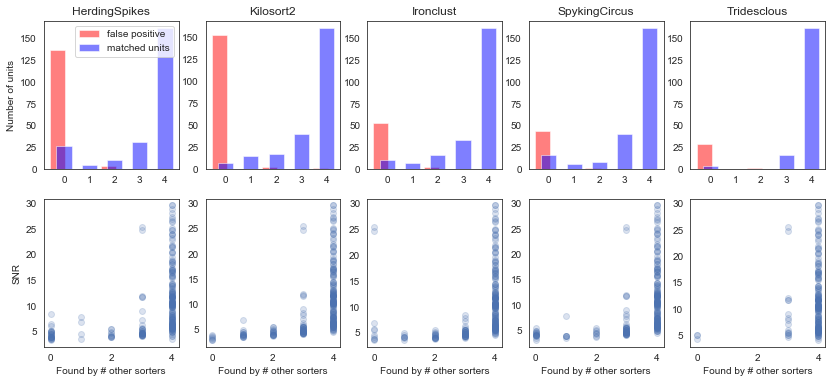

In [22]:
# count subgraph size for gt and non-gt units
results_df = pd.DataFrame()
plt.figure(figsize=(14, 6))
fp_units = []
snrs_gt = snr
for sorter in range(len(sorter_list)):
    found  = []
    notfound  = []
    found_snr = []
    notfound_units = []
    for sg in zip(in_gt, sg_sorters, in_gt_units, sg_units):
        b,s,u_gt,u = sg
        if sorter in s:
            if b[s.index(sorter)]:
                found.append((len(b), np.sum(b)))
                found_snr.append(snrs_gt[SX_gt.get_unit_ids()[u_gt[s.index(sorter)]]])
            else:
                notfound.append((len(b), np.sum(b)))
                notfound_units.append(u)
    plt.subplot(2,len(sorter_list),sorter+1)
    if len(notfound):
        v,c = np.unique(np.array(notfound)[:,0], return_counts=True)
        plt.bar(v-1-0.25,c, alpha=0.5, width = 0.6, color='r', label='false positive')
    v,c = np.unique(np.array(found)[:,0], return_counts=True)
    plt.bar(v-1,c, alpha=0.5, width = 0.6, color='b', label='matched units')
    plt.xticks(range(len(sorter_list)))
    if sorter==0:
        plt.legend()
#         plt.xlabel('Found by # other sorters')
        plt.ylabel('Number of units')
    plt.title(sorter_names[sorter])

    
    plt.subplot(2,len(sorter_list),sorter+1+len(sorter_list))
    plt.scatter(np.array(found)[:,0]-1, found_snr, alpha=0.2) 
    plt.xlabel('Found by # other sorters')
    if sorter==0:
        plt.ylabel('SNR')
    
    df = pd.DataFrame({'found':np.array(found)[:,0]-1,'SNR': found_snr,'sorter':sorter_names_short[sorter]})
    results_df = results_df.append(df)
    fp_units.append(notfound_units)


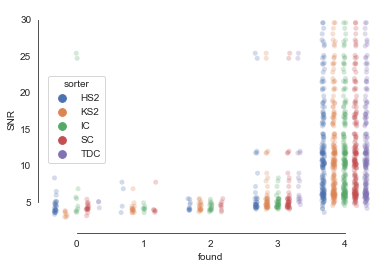

In [23]:
sns.stripplot(data=results_df, x='found', y='SNR', hue='sorter', dodge=True, alpha=0.25)
sns.despine(offset=5, trim=True)